In [1]:
from __future__ import absolute_import, division, print_function

# Demographic study

## Preliminaries

The trip data set has a column for information on gender and age. This information is extremely sparse for 'Customer' type users (2% in 2016 and 0% in 2015). For the 'Subscriber'-type user the information is fairly complete (~99%).  

## Imports

In [2]:
import datetime
import os
import sys
import subprocess
import glob

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.patches as mpatches


%matplotlib inline

In [3]:
# https://github.com/tinybike/weightedstats
# 
def weighted_median(data, weights=None):
    """Calculate the weighted median of a list."""
    if weights is None:
        return median(data)
    midpoint = 0.5 * sum(weights)
    if any([j > midpoint for j in weights]):
        return data[weights.index(max(weights))]
    if any([j > 0 for j in weights]):
        sorted_data, sorted_weights = zip(*sorted(zip(data, weights)))
        cumulative_weight = 0
        below_midpoint_index = 0
        while cumulative_weight <= midpoint:
            below_midpoint_index += 1
            cumulative_weight += sorted_weights[below_midpoint_index-1]
        cumulative_weight -= sorted_weights[below_midpoint_index-1]
        if cumulative_weight - midpoint < sys.float_info.epsilon:
            bounds = sorted_data[below_midpoint_index-2:below_midpoint_index]
            return sum(bounds) / float(len(bounds))
        return sorted_data[below_midpoint_index-1]
    


In [4]:
# https://github.com/nudomarinero/wquantiles/
def quantile_1D(data, weights, quantile):
    """
    Compute the weighted quantile of a 1D numpy array.
    Parameters
    ----------
    data : ndarray
        Input array (one dimension).
    weights : ndarray
        Array with the weights of the same size of `data`.
    quantile : float
        Quantile to compute. It must have a value between 0 and 1.
    Returns
    -------
    quantile_1D : float
        The output value.
    """
    # Check the data
    if not isinstance(data, np.matrix):
        data = np.asarray(data)
    if not isinstance(weights, np.matrix):
        weights = np.asarray(weights)
    nd = data.ndim
    if nd != 1:
        raise TypeError("data must be a one dimensional array")
    ndw = weights.ndim
    if ndw != 1:
        raise TypeError("weights must be a one dimensional array")
    if data.shape != weights.shape:
        raise TypeError("the length of data and weights must be the same")
    if ((quantile > 1.) or (quantile < 0.)):
        raise ValueError("quantile must have a value between 0. and 1.")
    # Sort the data
    ind_sorted = np.argsort(data)
    sorted_data = data[ind_sorted]
    sorted_weights = weights[ind_sorted]
    # Compute the auxiliary arrays
    Sn = np.cumsum(sorted_weights)
    # TODO: Check that the weights do not sum zero
    #assert Sn != 0, "The sum of the weights must not be zero"
    Pn = (Sn-0.5*sorted_weights)/np.sum(sorted_weights)
    # Get the value of the weighted median
    return np.interp(quantile, Pn, sorted_data)


def quantile(data, weights, quantile):
    """
    Weighted quantile of an array with respect to the last axis.
    Parameters
    ----------
    data : ndarray
        Input array.
    weights : ndarray
        Array with the weights. It must have the same size of the last 
        axis of `data`.
    quantile : float
        Quantile to compute. It must have a value between 0 and 1.
    Returns
    -------
    quantile : float
        The output value.
    """
    # TODO: Allow to specify the axis
    nd = data.ndim
    if nd == 0:
        TypeError("data must have at least one dimension")
    elif nd == 1:
        return quantile_1D(data, weights, quantile)
    elif nd > 1:
        n = data.shape
        imr = data.reshape((np.prod(n[:-1]), n[-1]))
        result = np.apply_along_axis(quantile_1D, -1, imr, weights, quantile)
        return result.reshape(n[:-1])


def median(data, weights):
    """
    Weighted median of an array with respect to the last axis.
    Alias for `quantile(data, weights, 0.5)`.
    """
    return quantile(data, weights, 0.5)

## Data

In [5]:
data_dir = os.path.join(os.getcwd(),'..','..','data')

In [6]:
df_2015 = pd.read_csv(os.path.join(data_dir,'subscriber_age_histogram_2015.csv'))
df_2016 = pd.read_csv(os.path.join(data_dir,'subscriber_age_histogram_2016.csv'))

In [7]:
df_2015.head()

,age,c,num_males,num_females
0,17,4199,3430,769
1,18,13454,11133,2321
2,19,17430,13795,3628
3,20,31769,22943,8376
4,21,43858,34218,9640


In [8]:
# Total number of rides taken by female customers in 2016
N_rides_female_2016 = df_2016['num_females'].sum()

In [9]:
# Total number of female customers in 2016
# In 2016, each subscriber took on average 112 rides (see citibike_02.ipynb)
N_female_2016 = round(N_rides_female_2016 / 112.)
print(N_female_2016)

26425.0


## Compare male and female cohort growth for 2015 and 2016

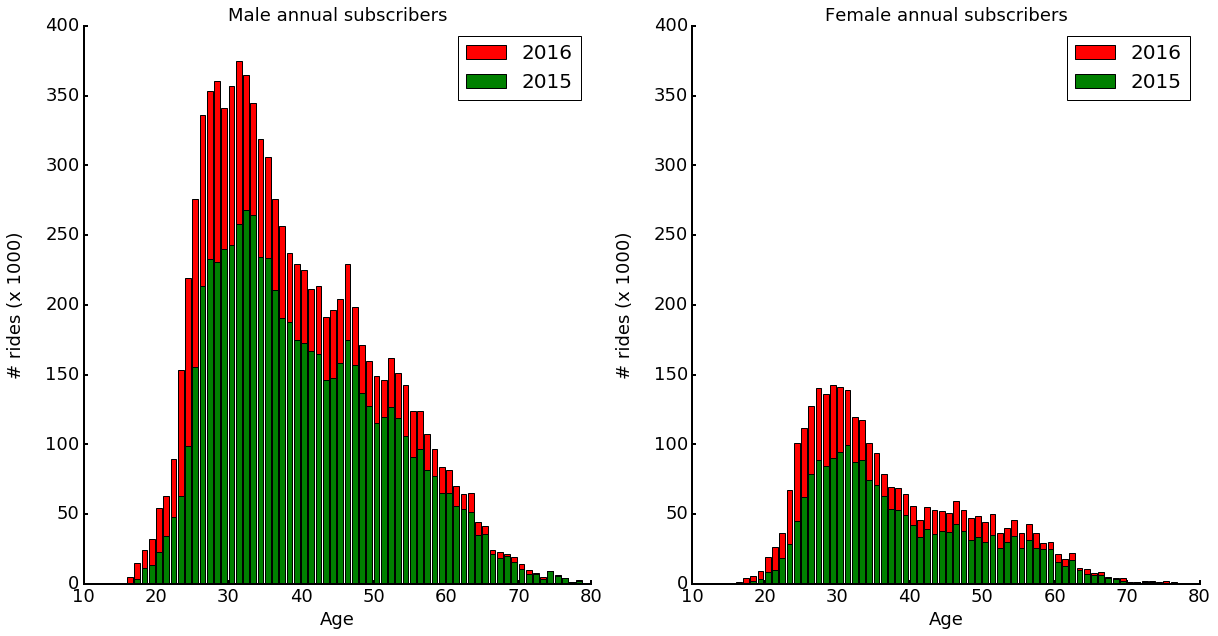

In [10]:
fig, ax = plt.subplots(1,2,figsize=(20, 10))
# Male
age = (df_2015['age'][df_2015['age'] < 90],df_2016['age'][df_2016['age'] < 90])
male = (df_2015['num_males'][df_2015['age'] < 90],df_2016['num_males'][df_2016['age'] < 90])
# the width of the bars
width = 0.8       
rects1 = ax[0].bar(age[1], [x/1e3 for x in male[1]], width, color='r', label='2016')
rects1 = ax[0].bar(age[0], [x/1e3 for x in male[0]], width, color='g', label='2015')
ax[0].set_title('Male annual subscribers', fontsize=18)
ax[0].set_xlabel('Age', fontsize=18)
ax[0].set_ylabel('# rides (x 1000)', fontsize=18, labelpad=20)
ax[0].legend(prop={'size': 20})
# Hide the right and top spines
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
# Set witdh of axes spines and ticks
ax[0].spines['left'].set_linewidth(2)
ax[0].spines['bottom'].set_linewidth(2)
ax[0].xaxis.set_tick_params(width=2)
ax[0].yaxis.set_tick_params(width=2)
# Only show ticks on the left and bottom spines
ax[0].yaxis.set_ticks_position('left')
ax[0].xaxis.set_ticks_position('bottom')
ax[0].tick_params(labelsize=18)
ax[0].set_xlim(10,80)
#
# Female
age = (df_2015['age'][df_2015['age'] < 90],df_2016['age'][df_2016['age'] < 90])
male = (df_2015['num_females'][df_2015['age'] < 90],df_2016['num_females'][df_2016['age'] < 90])
# the width of the bars
width = 0.8       
rects1 = ax[1].bar(age[1], [x/1e3 for x in male[1]], width, color='r', label='2016')
rects1 = ax[1].bar(age[0], [x/1e3 for x in male[0]], width, color='g', label='2015')
ax[1].set_title('Female annual subscribers', fontsize=18)
ax[1].set_xlabel('Age', fontsize=18)
ax[1].set_ylabel('# rides (x 1000)', fontsize=18, labelpad=20)
ax[1].legend(prop={'size': 20})
# Hide the right and top spines
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
# Set witdh of axes spines and ticks
ax[1].spines['left'].set_linewidth(2)
ax[1].spines['bottom'].set_linewidth(2)
ax[1].xaxis.set_tick_params(width=2)
ax[1].yaxis.set_tick_params(width=2)
# Only show ticks on the left and bottom spines
ax[1].yaxis.set_ticks_position('left')
ax[1].xaxis.set_ticks_position('bottom')
ax[1].tick_params(labelsize=18)
ax[1].set_xlim(10,80)
ax[1].set_ylim(0,400)
#
plt.savefig(os.path.join(data_dir,'plots','subscriber_demographics_2015_2016.pdf'), bbox_inches='tight')


(0, 400)

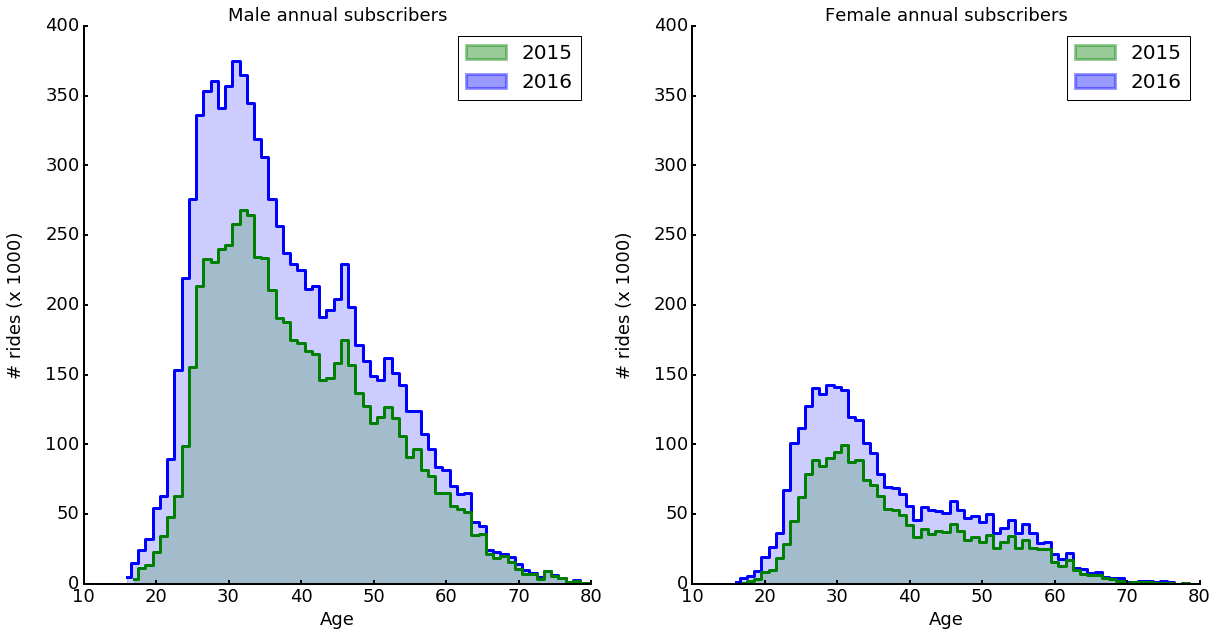

In [11]:
# Same as above but in a different style/color
fig, ax = plt.subplots(1,2,figsize=(20, 10))
# Male
age = (df_2015['age'][df_2015['age'] < 90],df_2016['age'][df_2016['age'] < 90])
male = (df_2015['num_males'][df_2015['age'] < 90],df_2016['num_males'][df_2016['age'] < 90])
# the width of the bars
width = 0.8       
ax[0].fill_between(age[1], 0, [x/1e3 for x in male[1]], step='mid', color='b', alpha=0.2)
rects1 = ax[0].step(age[1], [x/1e3 for x in male[1]], where='mid', color='b', label='2016', lw=3)
ax[0].fill_between(age[0], 0, [x/1e3 for x in male[0]], step='mid', color='g', alpha=0.2)
rects1 = ax[0].step(age[0], [x/1e3 for x in male[0]], where='mid', color='g', label='2015', lw=3)
#
ax[0].set_title('Male annual subscribers', fontsize=18)
ax[0].set_xlabel('Age', fontsize=18)
ax[0].set_ylabel('# rides (x 1000)', fontsize=18, labelpad=20)
green_patch = mpatches.Patch(label='2015', alpha=0.4, edgecolor='g', facecolor='g', lw=3)
blue_patch = mpatches.Patch(label='2016', alpha=0.4, edgecolor='b', facecolor='b', lw=3)
ax[0].legend(handles=[green_patch,blue_patch], prop={'size': 20})
# Hide the right and top spines
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
# Set witdh of axes spines and ticks
ax[0].spines['left'].set_linewidth(2)
ax[0].spines['bottom'].set_linewidth(2)
ax[0].xaxis.set_tick_params(width=2)
ax[0].yaxis.set_tick_params(width=2)
# Only show ticks on the left and bottom spines
ax[0].yaxis.set_ticks_position('left')
ax[0].xaxis.set_ticks_position('bottom')
ax[0].tick_params(labelsize=18)
ax[0].set_xlim(10,80)
#
# Female
age = (df_2015['age'][df_2015['age'] < 90],df_2016['age'][df_2016['age'] < 90])
male = (df_2015['num_females'][df_2015['age'] < 90],df_2016['num_females'][df_2016['age'] < 90])
# the width of the bars
width = 0.8       
ax[1].fill_between(age[1], 0, [x/1e3 for x in male[1]], step='mid', color='b',label='2016', alpha=0.2)
rects1 = ax[1].step(age[1], [x/1e3 for x in male[1]], where='mid', color='b',  lw=3)
ax[1].fill_between(age[0], 0, [x/1e3 for x in male[0]], step='mid', color='g',label='2015', alpha=0.2)
rects1 = ax[1].step(age[0], [x/1e3 for x in male[0]], where='mid', color='g',  lw=3)


ax[1].set_title('Female annual subscribers', fontsize=18)
ax[1].set_xlabel('Age', fontsize=18)
ax[1].set_ylabel('# rides (x 1000)', fontsize=18, labelpad=20)
green_patch = mpatches.Patch(label='2015', alpha=0.4, edgecolor='g', facecolor='g', lw=3)
blue_patch = mpatches.Patch(label='2016', alpha=0.4, edgecolor='b', facecolor='b', lw=3)
ax[1].legend(handles=[green_patch,blue_patch], prop={'size': 20})

# Hide the right and top spines
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
# Set witdh of axes spines and ticks
ax[1].spines['left'].set_linewidth(2)
ax[1].spines['bottom'].set_linewidth(2)
ax[1].xaxis.set_tick_params(width=2)
ax[1].yaxis.set_tick_params(width=2)
# Only show ticks on the left and bottom spines
ax[1].yaxis.set_ticks_position('left')
ax[1].xaxis.set_ticks_position('bottom')
ax[1].tick_params(labelsize=18)
ax[1].set_xlim(10,80)
ax[1].set_ylim(0,400)
#
# plt.savefig(os.path.join(data_dir,'plots','subscriber_demographics_2015_2016.pdf'), bbox_inches='tight')



## Compare new data with original data

Reacreate histogram shown at https://cloud.google.com/blog/big-data/2016/12/analyzing-nyc-biking-data-with-google-bigquery 

In [12]:
df_tmp = pd.read_csv(os.path.join(data_dir,'gender_age_histogram.csv'))

In [13]:
df_tmp.head()

,age,c,num_males,num_females
0,31,1311169,948942,359984
1,32,1275647,951459,321949
2,33,1261772,942443,317718
3,30,1249087,892019,356424
4,29,1194270,858725,335029


(10, 80)

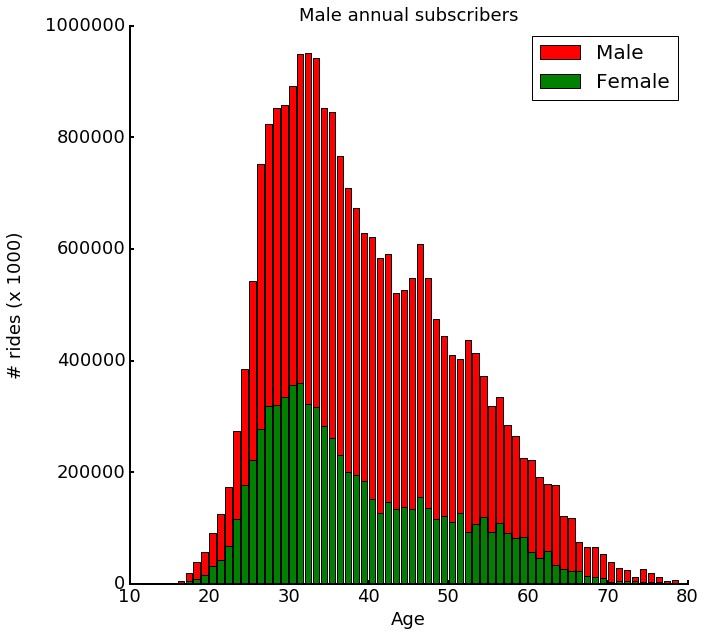

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))
# Male
age = df_tmp['age'][df_tmp['age'] < 90]
male = df_tmp['num_males'][df_tmp['age'] < 90]
female = df_tmp['num_females'][df_tmp['age'] < 90]
# the width of the bars
width = 0.8       
rects1 = ax.bar(age, male, width, color='r', label='Male')
rects1 = ax.bar(age, female, width, color='g', label='Female')
ax.set_title('Male annual subscribers', fontsize=18)
ax.set_xlabel('Age', fontsize=18)
ax.set_ylabel('# rides (x 1000)', fontsize=18, labelpad=20)
ax.legend(prop={'size': 20})
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Set witdh of axes spines and ticks
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.tick_params(labelsize=18)
ax.set_xlim(10,80)
#



This looks quite different from the plot on the website linked above.

In [15]:
df_tmp = pd.read_csv(os.path.join(data_dir,'gender_age_histogram_google.csv'))

In [ ]:
df_tmp.head()

,age,c,num_males,num_females
0,31,1240336,898453,340179
1,32,1215430,907695,306279
2,33,1207236,903267,302756
3,30,1176419,841542,334341
4,29,1122408,809837,312188


In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
# Male
age = df_tmp['age'][df_tmp['age'] < 90]
male = df_tmp['num_males'][df_tmp['age'] < 90]
female = df_tmp['num_females'][df_tmp['age'] < 90]
# the width of the bars
width = 0.8       
rects1 = ax.bar(age, male, width, color='r', label='Male')
rects1 = ax.bar(age, female, width, color='g', label='Female')
ax.set_title('Male annual subscribers', fontsize=18)
ax.set_xlabel('Age', fontsize=18)
ax.set_ylabel('# rides (x 1000)', fontsize=18, labelpad=20)
ax.legend(prop={'size': 20})
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Set witdh of axes spines and ticks
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.tick_params(labelsize=18)
ax.set_xlim(10,80)
#

(10, 80)

Even with the data taken from the google bigquery site it looks very different.

In [ ]:
# Now let's try the original data from
# https://exploratory.io/viz/7285328289418862/2952058795271396?cb=1478111542984

In [ ]:
df_tmp = pd.read_csv(os.path.join(data_dir,'gender_age_histogram_source.csv'))

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
# Male
age = df_tmp['age'][df_tmp['age'] < 90]
male = df_tmp['num_males'][df_tmp['age'] < 90]
female = df_tmp['num_females'][df_tmp['age'] < 90]
# the width of the bars
width = 0.8       
rects1 = ax.bar(age, male, width, color='r', label='Male')
rects1 = ax.bar(age, female, width, color='g', label='Female')
ax.set_title('Male annual subscribers', fontsize=18)
ax.set_xlabel('Age', fontsize=18)
ax.set_ylabel('# rides (x 1000)', fontsize=18, labelpad=20)
ax.legend(prop={'size': 20})
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Set witdh of axes spines and ticks
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.tick_params(labelsize=18)
ax.set_xlim(10,80)
#

Still very different. I don't know how they managed to create a histogram that showed such a higher fraction of females than males. In the original plot they even show female rides *higher* than male rides.

### Exploring the entries in the bars in the intercative plot on the exploratory.io website shows that female data is *stacked* on male data! That's were the discrepancy in the appearance comes from.

## Determine percentage growth per age bin for male and femal customers

In [ ]:
# Percent growth ratios
condition = (df_2015['age'] > 20) & (df_2015['age'] < 70)
age_2015 = df_2015['age'][condition].tolist()
ratio_male = []
ratio_male_err = []
for tmp_age in age_2015:
    tmp_num_2015 = df_2015['num_males'][df_2015['age'] == tmp_age].iloc[0]
    tmp_num_2016 = df_2016['num_males'][df_2016['age'] == tmp_age].iloc[0]
    tmp_diff = (tmp_num_2016-tmp_num_2015)
    tmp_denom = tmp_num_2015
    tmp = (tmp_diff / tmp_denom)
    ratio_male.append(tmp*100)
    # Assume Poisson error and propagate
    tmp_err_1 = np.sqrt(tmp_num_2015)
    tmp_err_2 = np.sqrt(tmp_num_2016)
    tmp_diff_err = np.sqrt((tmp_err_1)**2 + (tmp_err_2)**2)
    tmp_err = np.sqrt((tmp_diff_err/tmp_diff)**2 + (tmp_err_1/tmp_denom)**2)
    ratio_male_err.append(tmp_err*tmp*100)
ratio_female = []
ratio_female_err = []
for tmp_age in age_2015:
    tmp_num_2015 = df_2015['num_females'][df_2015['age'] == tmp_age].iloc[0]
    tmp_num_2016 = df_2016['num_females'][df_2016['age'] == tmp_age].iloc[0]
    tmp_diff = (tmp_num_2016-tmp_num_2015)
    tmp_denom = tmp_num_2015
    tmp = (tmp_diff / tmp_denom)
    ratio_female.append(tmp*100)
    # Assume Poisson error and propagate
    tmp_err_1 = np.sqrt(tmp_num_2015)
    tmp_err_2 = np.sqrt(tmp_num_2016)
    tmp_diff_err = np.sqrt((tmp_err_1)**2 + (tmp_err_2)**2)
    tmp_err = np.sqrt((tmp_diff_err/tmp_diff)**2 + (tmp_err_1/tmp_denom)**2)
    ratio_female_err.append(tmp_err*tmp*100)


In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
#
skip_begin = 4
skip_end = 1
tmp_x = age_2015[skip_begin:-skip_end]
tmp_y_male = ratio_male[skip_begin:-skip_end]
tmp_y_male_err = ratio_male_err[skip_begin:-skip_end]
tmp_y_female = ratio_female[skip_begin:-skip_end]
tmp_y_female_err = ratio_female_err[skip_begin:-skip_end]
#
plt.plot(tmp_x,tmp_y_male, color='green', label='Male', lw=1)
plt.plot(tmp_x,tmp_y_female, color='blue', label='Female', lw=1)
plt.title('Growth in subscribers per cohort\n(2015 to 2016)', fontsize=24)
plt.xlabel('Age', fontsize=18)
plt.ylabel('Percent', fontsize=18, labelpad=20)
# Make legend lines thicker
blue_line = mlines.Line2D([], [], color='blue', 
                          lw=3, label='Female')
green_line = mlines.Line2D([], [], color='green', 
                          lw=3, label='Male')

plt.legend(prop={'size': 20},handles=[blue_line,green_line])
# Show error margins
tmp_lower = [x-y for x,y in zip(tmp_y_male,tmp_y_male_err)]
tmp_upper = [x+y for x,y in zip(tmp_y_male,tmp_y_male_err)]
ax.fill_between(tmp_x, tmp_upper, tmp_lower, facecolor='green', alpha=.5,)
# Show error margins
tmp_lower = [x-y for x,y in zip(tmp_y_female,tmp_y_female_err)]
tmp_upper = [x+y for x,y in zip(tmp_y_female,tmp_y_female_err)]
ax.fill_between(tmp_x, tmp_upper, tmp_lower, facecolor='blue', alpha=.5,)
#
ax.set_ylim(0,100)
# ax.set_xlim(20,40)
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Set witdh of axes spines and ticks
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.tick_params(labelsize=18)
# 
# ax.text(0.15, 0.65, 'From 2015 to 2016, female annual customers (age 35-55) grew\nstronger than male annual customers of the same age group.\n(+500 customers)', style='italic',
#         horizontalalignment='left', bbox={'facecolor':'lightblue', 'alpha':0.5, 'pad':10},
#         transform=ax.transAxes,fontsize=20)
#
plt.savefig(os.path.join(data_dir,'plots','growth_subscriber_demographics_2015_2016.pdf'), bbox_inches='tight')
#


## Determine extra growth in female customers 2015 -> 2016 at ages 35-55

In [ ]:
age1 = 35
age2 = 55
# find the aggregated number of rides per gender in the age bracket
n_female_2015 = df_2015['num_females'][(df_2015['age'] >= age1) & (df_2015['age'] <= age2)].sum()
n_female_2016 = df_2016['num_females'][(df_2016['age'] >= age1) & (df_2016['age'] <= age2)].sum()
n_male_2015 = df_2015['num_males'][(df_2015['age'] >= age1) & (df_2015['age'] <= age2)].sum()
n_male_2016 = df_2016['num_males'][(df_2016['age'] >= age1) & (df_2016['age'] <= age2)].sum()
print(n_male_2015, n_female_2015)
print(n_male_2016, n_female_2016)
# If female customers had grown at the same rate as the males, what would have been the number of female customers?
growth_ratio_male = n_male_2016/n_male_2015
growth_ratio_female = n_female_2016/n_female_2015
print('Growth ratios:', growth_ratio_male, growth_ratio_female)
print('Growth percetages:', 100*(n_male_2016-n_male_2015)/n_male_2015, 100*(n_female_2016-n_female_2015)/n_female_2015)

print(100*(growth_ratio_female-growth_ratio_male)/growth_ratio_male)
n_female_2016_hypo = int(round(growth_ratio_male*n_female_2015))
print(n_female_2016_hypo, n_female_2016)
diff = n_female_2016-n_female_2016_hypo
print('Difference in # rides: {}'.format(diff))
print('Difference in # of customers (assuming 112 rides per customer per year): {}'.format((diff)/112))

In [ ]:
# Now do the same by using weighted averages/medians in the age bracket
age1 = 35
age2 = 55
# find the number of rides per gender and age in the age bracket
n_female_2015 = df_2015['num_females'][(df_2015['age'] >= age1) & (df_2015['age'] <= age2)].tolist()
n_female_2016 = df_2016['num_females'][(df_2016['age'] >= age1) & (df_2016['age'] <= age2)].tolist()
n_male_2015 = df_2015['num_males'][(df_2015['age'] >= age1) & (df_2015['age'] <= age2)].tolist()
n_male_2016 = df_2016['num_males'][(df_2016['age'] >= age1) & (df_2016['age'] <= age2)].tolist()
# Determine the weighted average of growth in the age bracket. Use combined numbers and weights.
growth_male_1 = np.average(n_male_2015,weights=n_male_2015)
growth_male_2 = np.average(n_male_2016,weights=n_male_2016)
growth_male_avg = growth_male_2/growth_male_1
growth_female_1 = np.average(n_female_2015,weights=n_female_2015)
growth_female_2 = np.average(n_female_2016,weights=n_female_2016)
growth_female_avg = growth_female_2/growth_female_1
print('Growth ratios:', growth_male_avg, growth_female_avg)

growth_male_1 = np.average(n_male_2015,weights=n_male_2015)
growth_male_2 = np.average(n_male_2016,weights=n_male_2016)
growth_male_avg = growth_male_2/growth_male_1
growth_female_1 = np.average(n_female_2015,weights=n_female_2015)
growth_female_2 = np.average([x-42000./len(n_female_2016) for x in n_female_2016],weights=[x-42000/len(n_female_2016) for x in n_female_2016])
growth_female_avg = growth_female_2/growth_female_1
print('Growth ratios:', growth_male_avg, growth_female_avg)
growth_male = np.average(np.array(n_male_2016)/np.array(n_male_2015),
                         weights=np.array([x+y for x,y in zip(n_male_2015,n_male_2016)]))
growth_female = np.average(np.array(n_female_2016)/np.array(n_female_2015),
                           weights=np.array([x+y for x,y in zip(n_female_2015,n_female_2016)]))
print('Growth ratios:', growth_male, growth_female)

# If female customers had grown at the same rate as the males, what would have been the number of female customers?
print(100*(growth_female-growth_male)/growth_male)
n_female_2016_hypo = int(round(growth_male*sum(n_female_2015)))
diff = sum(n_female_2016)-n_female_2016_hypo
print('Difference in # rides: {}'.format(diff))
print('Difference in # of customers (assuming 112 rides per customer per year): {}'.format((diff)/112))

## Compare age group usage for male and femal customers

In [ ]:
age_2015 = df_2015['age'][df_2015['age'] < 70]
ratio_2015 = (df_2015['num_males'][df_2015['age'] < 70] / df_2015['num_females'][df_2015['age'] < 70]).tolist()
tmp_ratio_2015_err = (((df_2015['num_males'][df_2015['age'] < 70].apply(np.sqrt) / 
                        df_2015['num_males'][df_2015['age'] < 70]).apply(lambda x: x**2) +
                       (df_2015['num_females'][df_2015['age'] < 70].apply(np.sqrt) / 
                        df_2015['num_females'][df_2015['age'] < 70]).apply(lambda x: x**2)).apply(np.sqrt)).tolist()
ratio_2015_err = [x*y for x,y in zip(ratio_2015,tmp_ratio_2015_err)]
#
age_2016 = df_2016['age'][df_2016['age'] < 70]
ratio_2016 = (df_2016['num_males'][df_2016['age'] < 70] / df_2016['num_females'][df_2016['age'] < 70]).tolist()
tmp_ratio_2016_err = (((df_2016['num_males'][df_2016['age'] < 70].apply(np.sqrt) / 
                        df_2016['num_males'][df_2016['age'] < 70]).apply(lambda x: x**2) +
                       (df_2016['num_females'][df_2016['age'] < 70].apply(np.sqrt) / 
                        df_2016['num_females'][df_2016['age'] < 70]).apply(lambda x: x**2)).apply(np.sqrt)).tolist()
ratio_2016_err = [x*y for x,y in zip(ratio_2016,tmp_ratio_2016_err)]




In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(age_2015,ratio_2015, color='green', label='2015', lw=3)
plt.plot(age_2016,ratio_2016, color='blue', label='2016', lw=3)
plt.title('Ratio of rides taken by male over female subscribers', fontsize=18)
plt.ylabel('Ratio (Male over Female)', fontsize=18)
plt.xlabel('Age', fontsize=18)
plt.legend(prop={'size': 20})
#
plt.plot([age_2015.iloc[0],age_2015.iloc[-1]],[np.median(ratio_2015),np.median(ratio_2015)],'g--', lw=3)
plt.plot([age_2016.iloc[0],age_2016.iloc[-1]],[np.median(ratio_2016),np.median(ratio_2016)],'b--', lw=3)
# Show error margins
tmp_lower = [x-y for x,y in zip(ratio_2015,ratio_2015_err)]
tmp_upper = [x+y for x,y in zip(ratio_2015,ratio_2015_err)]
ax.fill_between(age_2015, tmp_upper, tmp_lower, facecolor='green', alpha=.5,)
# Show error margins
tmp_lower = [x-y for x,y in zip(ratio_2016,ratio_2016_err)]
tmp_upper = [x+y for x,y in zip(ratio_2016,ratio_2016_err)]
ax.fill_between(age_2016, tmp_upper, tmp_lower, facecolor='blue', alpha=.5,)
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Set witdh of axes spines and ticks
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.tick_params(labelsize=18)
#
plt.savefig(os.path.join(data_dir,'plots','ride_ratio_subscriber_demographics_2015_2016.pdf'), bbox_inches='tight')


## Compare age group usage for male and femal customers - Part II

Same as above, but replace the straight median with weighted (by number of customers/rides in bin) median.

In [ ]:
# Determine median/average ratios weighted by #_of_rides/customers
# age_2015 = df_2015['age'][df_2015['age'] < 70]
# ratio_2015 = (df_2015['num_males'][df_2015['age'] < 70] / df_2015['num_females'][df_2015['age'] < 70]).tolist()
combined_num_2015 = (df_2015['num_males'][df_2015['age'] < 70]+df_2015['num_females'][df_2015['age'] < 70]).tolist()
combined_num_2016 = (df_2016['num_males'][df_2016['age'] < 70]+df_2016['num_females'][df_2016['age'] < 70]).tolist()


In [ ]:
# Weighted average
avg_2015_weighted = np.average(ratio_2015,weights=combined_num_2015)
avg_2016_weighted = np.average(ratio_2016,weights=combined_num_2016)
print(avg_2015_weighted,avg_2016_weighted)

In [ ]:
# Weighted median using one piece of code (see at the beginning)
print(median(np.array(ratio_2015),np.array(combined_num_2015)))
print(median(np.array(ratio_2016),np.array(combined_num_2016)))

In [ ]:
# Weighted median using a different piece of code (see at the beginning)
print(weighted_median(ratio_2015,weights=combined_num_2015))
print(weighted_median(ratio_2016,weights=combined_num_2016))

The different weighted median codes result in slightly different results. For link to code source see above where functions are defined. 

Notably, the weighted *median* values are always below the weigted *average* values.

In [ ]:
# Run weighted median from very simple approximation:
# each age group ratio appears as often as its weight (combined number of rides).
# Then take the median of the resulting array.
l1 = ratio_2015
l2 = combined_num_2015
out = np.zeros(0)
out = []
for i,j in zip(l1,l2):
    out = out + [i]*j
print(len(out))
print(np.median(out))    
        

In [ ]:
# Same as above for 2016
l1 = ratio_2016
l2 = combined_num_2016
out = np.zeros(0)
out = []
for i,j in zip(l1,l2):
    out = out + [i]*j
print(len(out))
print(np.median(out))    



In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
#
skip_begin = 0
skip_end = 1
#
tmp_x = age_2015[skip_begin:-skip_end]
tmp_y_ratio = ratio_2015[skip_begin:-skip_end]
tmp_y_ratio_err = ratio_2015_err[skip_begin:-skip_end]
#
# plt.plot(tmp_x,tmp_y_ratio, color='green', label='2015', lw=3)
# Show error margins
tmp_lower = [x-y for x,y in zip(tmp_y_ratio,tmp_y_ratio_err)]
tmp_upper = [x+y for x,y in zip(tmp_y_ratio,tmp_y_ratio_err)]
# ax.fill_between(tmp_x, tmp_upper, tmp_lower, facecolor='green', alpha=.5,)
# plt.plot([age_2015.iloc[0],age_2015.iloc[-1]],[3.3,3.3],'g--', lw=3,label='2015 median (wgt)')
skip_begin = 0
skip_end = 1
#
tmp_x = age_2016[skip_begin:-skip_end]
tmp_y_ratio = ratio_2016[skip_begin:-skip_end]
tmp_y_ratio_err = ratio_2016_err[skip_begin:-skip_end]
#
plt.plot(tmp_x,tmp_y_ratio, color='blue', label='2016', lw=3)
# Show error margins
tmp_lower = [x-y for x,y in zip(tmp_y_ratio,tmp_y_ratio_err)]
tmp_upper = [x+y for x,y in zip(tmp_y_ratio,tmp_y_ratio_err)]
ax.fill_between(tmp_x, tmp_upper, tmp_lower, facecolor='blue', alpha=.5,)
#
plt.title('Ratio of male over female subscribers', fontsize=24)
plt.ylabel('Ratio (Male over Female)', fontsize=18)
plt.xlabel('Age', fontsize=18)
#
plt.plot([age_2016.iloc[0],age_2016.iloc[-1]],[3.1,3.1],'b--', lw=3,label='median (wgt)')
#
plt.legend(prop={'size': 20}, loc=2)
# Show error margins
tmp_lower = [x-y for x,y in zip(ratio_2016,ratio_2016_err)]
tmp_upper = [x+y for x,y in zip(ratio_2016,ratio_2016_err)]
ax.fill_between(age_2016, tmp_upper, tmp_lower, facecolor='blue', alpha=.5,)
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Set witdh of axes spines and ticks
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.tick_params(labelsize=18)
#
plt.savefig(os.path.join(data_dir,'plots','ride_ratio_subscriber_demographics_2016.pdf'), bbox_inches='tight')



## Compare age group usage for male and femal customers - Histogram

Explore if a histogram representation can make the result above a bit easier to access.

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20, 10))
# Data
age = df_2016['age'][df_2016['age'] < 90]
male = df_2016['num_males'][df_2016['age'] < 90]
female = df_2016['num_females'][df_2016['age'] < 90]
# the width of the bars
width = 0.8       
ax[0].fill_between(age, 0, male/1e3, step='mid', color='b',label='Male', alpha=0.2)
rects1 = ax[0].step(age, male/1e3, where='mid', color='b',  lw=3)
ax[0].fill_between(age, 0, female/1e3, step='mid', color='g',label='Female', alpha=0.2)
rects1 = ax[0].step(age, female/1e3, where='mid', color='g',  lw=3)
# Labels
ax[0].set_title('Annual subscribers 2016', fontsize=18)
ax[0].set_xlabel('Age', fontsize=18)
ax[0].set_ylabel('# rides (x 1000)', fontsize=18, labelpad=20)
green_patch = mpatches.Patch(label='Female', alpha=0.4, edgecolor='g', facecolor='g', lw=3)
blue_patch = mpatches.Patch(label='Male', alpha=0.4, edgecolor='b', facecolor='b', lw=3)
ax[0].legend(handles=[blue_patch,green_patch], prop={'size': 20})
# Hide the right and top spines
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
# Set witdh of axes spines and ticks
ax[0].spines['left'].set_linewidth(2)
ax[0].spines['bottom'].set_linewidth(2)
ax[0].xaxis.set_tick_params(width=2)
ax[0].yaxis.set_tick_params(width=2)
# Only show ticks on the left and bottom spines
ax[0].yaxis.set_ticks_position('left')
ax[0].xaxis.set_ticks_position('bottom')
ax[0].tick_params(labelsize=18)
ax[0].set_xlim(10,80)
# Scaled data
scale_factor = max(male)/max(female)
print('Scale factor: {}'.format(scale_factor))
female_scaled = female*scale_factor
# the width of the bars
width = 0.8       
ax[1].fill_between(age, 0, male/1e3, step='mid', color='b',label='Male', alpha=0.2)
rects1 = ax[1].step(age, male/1e3, where='mid', color='b',  lw=3)
ax[1].fill_between(age, 0, female_scaled/1e3, step='mid', color='g',label='Female', alpha=0.2)
rects1 = ax[1].step(age, female_scaled/1e3, where='mid', color='g',  lw=3)
# Labels
ax[1].set_title('Annual subscribers 2016', fontsize=18)
ax[1].set_xlabel('Age', fontsize=18)
ax[1].set_ylabel('# rides (x 1000)', fontsize=18, labelpad=20)
green_patch = mpatches.Patch(label='Female x 2.6', alpha=0.4, edgecolor='g', facecolor='g', lw=3)
blue_patch = mpatches.Patch(label='Male', alpha=0.4, edgecolor='b', facecolor='b', lw=3)
ax[1].legend(handles=[blue_patch,green_patch], prop={'size': 20})
# Hide the right and top spines
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
# Set witdh of axes spines and ticks
ax[1].spines['left'].set_linewidth(2)
ax[1].spines['bottom'].set_linewidth(2)
ax[1].xaxis.set_tick_params(width=2)
ax[1].yaxis.set_tick_params(width=2)
# Only show ticks on the left and bottom spines
ax[1].yaxis.set_ticks_position('left')
ax[1].xaxis.set_ticks_position('bottom')
ax[1].tick_params(labelsize=18)
ax[1].set_xlim(10,80)
plt.savefig(os.path.join(data_dir,'plots','subscriber_demographics_2016.pdf'), bbox_inches='tight')





## Animate the scaling 

In [ ]:
n_steps = 17
# Data
age = df_2016['age'][df_2016['age'] < 90]
male = df_2016['num_males'][df_2016['age'] < 90]
female = df_2016['num_females'][df_2016['age'] < 90]
# Scaled data
scale_factor = max(male)/max(female)
print('Max scale factor: {}'.format(scale_factor))
female_scaled = female*scale_factor
# 
steps = np.linspace(1.0,scale_factor,n_steps)
for idx,step in enumerate(steps):
    female_scaled = female*step
    print('Plotting scale factor {:02.1f}'.format(step))
    #
    fig, ax = plt.subplots(1,2,figsize=(20, 10))
    # the width of the bars
    width = 0.8       
    ax[0].fill_between(age, 0, male/1e3, step='mid', color='b',label='Male', alpha=0.2)
    rects1 = ax[0].step(age, male/1e3, where='mid', color='b',  lw=3)
    ax[0].fill_between(age, 0, female/1e3, step='mid', color='g',label='Female', alpha=0.2)
    rects1 = ax[0].step(age, female/1e3, where='mid', color='g',  lw=3)
    # Labels
    ax[0].set_title('Annual subscribers 2016', fontsize=18)
    ax[0].set_xlabel('Age', fontsize=18)
    ax[0].set_ylabel('# rides (x 1000)', fontsize=18, labelpad=20)
    green_patch = mpatches.Patch(label='Female', alpha=0.4, edgecolor='g', facecolor='g', lw=3)
    blue_patch = mpatches.Patch(label='Male', alpha=0.4, edgecolor='b', facecolor='b', lw=3)
    ax[0].legend(handles=[blue_patch,green_patch], prop={'size': 20})
    # Hide the right and top spines
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['top'].set_visible(False)
    # Set witdh of axes spines and ticks
    ax[0].spines['left'].set_linewidth(2)
    ax[0].spines['bottom'].set_linewidth(2)
    ax[0].xaxis.set_tick_params(width=2)
    ax[0].yaxis.set_tick_params(width=2)
    # Only show ticks on the left and bottom spines
    ax[0].yaxis.set_ticks_position('left')
    ax[0].xaxis.set_ticks_position('bottom')
    ax[0].tick_params(labelsize=18)
    ax[0].set_xlim(10,80)
    # the width of the bars
    width = 0.8       
    ax[1].fill_between(age, 0, male/1e3, step='mid', color='b',label='Male', alpha=0.2)
    rects1 = ax[1].step(age, male/1e3, where='mid', color='b',  lw=3)
    ax[1].fill_between(age, 0, female_scaled/1e3, step='mid', color='g',label='Female', alpha=0.2)
    rects1 = ax[1].step(age, female_scaled/1e3, where='mid', color='g',  lw=3)
    # Labels
    ax[1].set_title('Annual subscribers 2016', fontsize=18)
    ax[1].set_xlabel('Age', fontsize=18)
    ax[1].set_ylabel('# rides (x 1000)', fontsize=18, labelpad=20)
    green_patch = mpatches.Patch(label='Female x {:2.1f}'.format(step), alpha=0.4, edgecolor='g', facecolor='g', lw=3)
    blue_patch = mpatches.Patch(label='Male', alpha=0.4, edgecolor='b', facecolor='b', lw=3)
    ax[1].legend(handles=[blue_patch,green_patch], prop={'size': 20})
    # Hide the right and top spines
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['top'].set_visible(False)
    # Set witdh of axes spines and ticks
    ax[1].spines['left'].set_linewidth(2)
    ax[1].spines['bottom'].set_linewidth(2)
    ax[1].xaxis.set_tick_params(width=2)
    ax[1].yaxis.set_tick_params(width=2)
    # Only show ticks on the left and bottom spines
    ax[1].yaxis.set_ticks_position('left')
    ax[1].xaxis.set_ticks_position('bottom')
    ax[1].tick_params(labelsize=18)
    ax[1].set_xlim(10,80)
    #
    plt.savefig(os.path.join(data_dir,'plots','subscriber_demographics_2016_anim_'+'{:02.0f}'.format(idx)+'.png'), bbox_inches='tight')
    plt.close()


In [ ]:
# Convert indiviudal plots to animated gif using command-line tools
# catch current directory
curr_dir = os.getcwd()
# change to plot directory
plot_path = os.path.join(data_dir,'plots')
os.chdir(plot_path)
# create animation
files = glob.glob('subscriber_demographics_2016_anim_*.png')
if len(files) == 0:
    print('Ooops...')
else:
    call = 'convert -delay 5 -loop 1 subscriber_demographics_2016_anim_*.png scaling.gif'
    subprocess.call(call.split(' '))
# return to original directory
os.chdir(curr_dir)


## Determine how many additional customers would be needed to fill the gap in F35+

In [ ]:
# Data
age = df_2016['age'][df_2016['age'] < 90].tolist()
male = df_2016['num_males'][df_2016['age'] < 90].tolist()
female = df_2016['num_females'][df_2016['age'] < 90].tolist()
# Scaled data
scale_factor = max(male)/max(female)
print('Scale factor: {}'.format(scale_factor))
female_scaled = [x*scale_factor for x in female]
# Determine number of 'missing rides'
n_total_missed = 0
for idx,tmp_age in enumerate(age):
    if tmp_age >= 35 and tmp_age <= 55:
        tmp_missed = male[idx] - female_scaled[idx]
        n_total_missed += tmp_missed
print('In 2016, {} rides were missing in the 35-55 age bracket '.format(n_total_missed)+
      'to match female and male engagement (modolo a scaling factor of 2.6)')        
n_total_missed_true = n_total_missed/scale_factor
print('Taking out the scaling factor leads to {:.0f} rides.'.format(round(n_total_missed_true)))        

print('Using a number of 103 rides / customer / year, this translates into '+
      '{:.0f} customers (F35+)'.format(round(n_total_missed_true/103.)))
print('Using the current price of an annual membership ($163) this would mean '+
      'a total increase in revenue of {:.0f} USD.'.format(round(n_total_missed_true/103.*163.)))


## Recreate the histograms showing male/female numbers in 2015/2016 in the same style

In [ ]:
# Same as above but in a different style/color
fig, ax = plt.subplots(1,2,figsize=(20, 10))
# Male
age = (df_2015['age'][df_2015['age'] < 90],df_2016['age'][df_2016['age'] < 90])
male = (df_2015['num_males'][df_2015['age'] < 90],df_2016['num_males'][df_2016['age'] < 90])
# the width of the bars
width = 0.8
norm_factor = max(male[1])
ax[0].fill_between(age[1], 0, [x/norm_factor for x in male[1]], step='mid', color='b', alpha=0.2)
rects1 = ax[0].step(age[1], [x/norm_factor for x in male[1]], where='mid', color='b', label='2016', lw=3)
ax[0].fill_between(age[0], 0, [x/norm_factor for x in male[0]], step='mid', color='g', alpha=0.2)
rects1 = ax[0].step(age[0], [x/norm_factor for x in male[0]], where='mid', color='g', label='2015', lw=3)
#
ax[0].set_title('Male', fontsize=24)
ax[0].set_xlabel('Age', fontsize=18)
ax[0].set_ylabel('# rides (normalized)', fontsize=18, labelpad=20)
green_patch = mpatches.Patch(label='2015', alpha=0.4, edgecolor='g', facecolor='g', lw=3)
blue_patch = mpatches.Patch(label='2016', alpha=0.4, edgecolor='b', facecolor='b', lw=3)
ax[0].legend(handles=[blue_patch,green_patch], prop={'size': 20})
# Hide the right and top spines
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
# Set witdh of axes spines and ticks
ax[0].spines['left'].set_linewidth(2)
ax[0].spines['bottom'].set_linewidth(2)
ax[0].xaxis.set_tick_params(width=2)
ax[0].yaxis.set_tick_params(width=2)
# Only show ticks on the left and bottom spines
ax[0].yaxis.set_ticks_position('left')
ax[0].xaxis.set_ticks_position('bottom')
ax[0].tick_params(labelsize=18)
ax[0].set_xlim(10,80)
#
# Female
age = (df_2015['age'][df_2015['age'] < 90],df_2016['age'][df_2016['age'] < 90])
female = (df_2015['num_females'][df_2015['age'] < 90],df_2016['num_females'][df_2016['age'] < 90])
# the width of the bars
norm_factor = max(female[1])
width = 0.8       
ax[1].fill_between(age[1], 0, [x/norm_factor for x in female[1]], step='mid', color='b',label='2016', alpha=0.2)
rects1 = ax[1].step(age[1], [x/norm_factor for x in female[1]], where='mid', color='b',  lw=3)
ax[1].fill_between(age[0], 0, [x/norm_factor for x in female[0]], step='mid', color='g',label='2015', alpha=0.2)
rects1 = ax[1].step(age[0], [x/norm_factor for x in female[0]], where='mid', color='g',  lw=3)


ax[1].set_title('Female', fontsize=24)
ax[1].set_xlabel('Age', fontsize=18)
ax[1].set_ylabel('# rides (normalized)', fontsize=18, labelpad=20)
green_patch = mpatches.Patch(label='2015', alpha=0.4, edgecolor='g', facecolor='g', lw=3)
blue_patch = mpatches.Patch(label='2016', alpha=0.4, edgecolor='b', facecolor='b', lw=3)
ax[1].legend(handles=[blue_patch,green_patch], prop={'size': 20})

# Hide the right and top spines
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
# Set witdh of axes spines and ticks
ax[1].spines['left'].set_linewidth(2)
ax[1].spines['bottom'].set_linewidth(2)
ax[1].xaxis.set_tick_params(width=2)
ax[1].yaxis.set_tick_params(width=2)
# Only show ticks on the left and bottom spines
ax[1].yaxis.set_ticks_position('left')
ax[1].xaxis.set_ticks_position('bottom')
ax[1].tick_params(labelsize=18)
ax[1].set_xlim(10,80)
# ax[1].set_ylim(0,400)
#
plt.savefig(os.path.join(data_dir,'plots','subscriber_growth_demographics_2015_2016.pdf'), bbox_inches='tight')



## Re-calcuate the growth, now as a ratio instead of a percentage. Plot in the same style.

In [ ]:
# Growth ratios
condition = (df_2015['age'] > 20) & (df_2015['age'] < 70)
age_2015 = df_2015['age'][condition].tolist()
ratio_male = []
ratio_male_err = []
for tmp_age in age_2015:
    tmp_num_2015 = df_2015['num_males'][df_2015['age'] == tmp_age].iloc[0]
    tmp_num_2016 = df_2016['num_males'][df_2016['age'] == tmp_age].iloc[0]
    tmp_ratio = tmp_num_2016/tmp_num_2015
    ratio_male.append(tmp_ratio)
    # Assume Poisson error and propagate
    tmp_err_1 = np.sqrt(tmp_num_2015)
    tmp_err_2 = np.sqrt(tmp_num_2016)
    tmp_ratio_err = np.sqrt((tmp_err_1/tmp_num_2015)**2 + (tmp_err_2/tmp_num_2016)**2)
    ratio_male_err.append(tmp_ratio_err*tmp_ratio)
ratio_female = []
ratio_female_err = []
for tmp_age in age_2015:
    tmp_num_2015 = df_2015['num_females'][df_2015['age'] == tmp_age].iloc[0]
    tmp_num_2016 = df_2016['num_females'][df_2016['age'] == tmp_age].iloc[0]
    tmp_ratio = tmp_num_2016/tmp_num_2015
    ratio_female.append(tmp_ratio)
    # Assume Poisson error and propagate
    tmp_err_1 = np.sqrt(tmp_num_2015)
    tmp_err_2 = np.sqrt(tmp_num_2016)
    tmp_ratio_err = np.sqrt((tmp_err_1/tmp_num_2015)**2 + (tmp_err_2/tmp_num_2016)**2)
    ratio_female_err.append(tmp_ratio_err*tmp_ratio)
ratio_diff = [x-y for x,y in zip(ratio_female,ratio_male)]

In [ ]:
# Same as above but in a different style/color
fig, ax = plt.subplots(1,2,figsize=(20, 10))
# Male
age = age_2015
# the width of the bars
width = 0.8       
ax[0].fill_between(age, 0, ratio_male, step='mid', color='b', alpha=0.2)
rects1 = ax[0].step(age, ratio_male, where='mid', color='b', lw=3)
#
ax[0].set_title('Male', fontsize=24)
ax[0].set_xlabel('Age', fontsize=18)
ax[0].set_ylabel('Growth 2015 $\\rightarrow$ 2016', fontsize=18, labelpad=20)
green_patch = mpatches.Patch(label='2015', alpha=0.4, edgecolor='g', facecolor='g', lw=3)
blue_patch = mpatches.Patch(label='2016', alpha=0.4, edgecolor='b', facecolor='b', lw=3)
ax[0].legend(handles=[green_patch,blue_patch], prop={'size': 20})
# Hide the right and top spines
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
# Set witdh of axes spines and ticks
ax[0].spines['left'].set_linewidth(2)
ax[0].spines['bottom'].set_linewidth(2)
ax[0].xaxis.set_tick_params(width=2)
ax[0].yaxis.set_tick_params(width=2)
# Only show ticks on the left and bottom spines
ax[0].yaxis.set_ticks_position('left')
ax[0].xaxis.set_ticks_position('bottom')
ax[0].tick_params(labelsize=18)
ax[0].set_xlim(10,80)
#
# Female
# the width of the bars
width = 0.8       
ax[1].fill_between(age, 0, ratio_female, step='mid', color='g', alpha=0.2)
rects1 = ax[1].step(age, ratio_female, where='mid', color='g', lw=3)
#
ax[1].set_title('Female', fontsize=24)
ax[1].set_xlabel('Age', fontsize=18)
ax[1].set_ylabel('Growth 2015 $\\rightarrow$ 2016', fontsize=18, labelpad=20)
green_patch = mpatches.Patch(label='2015', alpha=0.4, edgecolor='g', facecolor='g', lw=3)
blue_patch = mpatches.Patch(label='2016', alpha=0.4, edgecolor='b', facecolor='b', lw=3)
ax[1].legend(handles=[green_patch,blue_patch], prop={'size': 20})

# Hide the right and top spines
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
# Set witdh of axes spines and ticks
ax[1].spines['left'].set_linewidth(2)
ax[1].spines['bottom'].set_linewidth(2)
ax[1].xaxis.set_tick_params(width=2)
ax[1].yaxis.set_tick_params(width=2)
# Only show ticks on the left and bottom spines
ax[1].yaxis.set_ticks_position('left')
ax[1].xaxis.set_ticks_position('bottom')
ax[1].tick_params(labelsize=18)
ax[1].set_xlim(10,80)

In [ ]:
# Same as above but in a different style/color
fig, ax = plt.subplots(figsize=(10, 10))
# Data
#
skip_begin = 4
skip_end = 1
tmp_x = age_2015[skip_begin:-skip_end]
tmp_y_male = ratio_male[skip_begin:-skip_end]
tmp_y_male_err = ratio_male_err[skip_begin:-skip_end]
tmp_y_female = ratio_female[skip_begin:-skip_end]
tmp_y_female_err = ratio_female_err[skip_begin:-skip_end]
# the width of the bars
width = 0.8       
ax.fill_between(tmp_x, 0, tmp_y_male, step='mid', color='b', alpha=0.2)
rects1 = ax.step(tmp_x, tmp_y_male, where='mid', color='b', lw=3)
ax.fill_between(tmp_x, 0, tmp_y_female, step='mid', color='g', alpha=0.2)
rects1 = ax.step(tmp_x, tmp_y_female, where='mid', color='g', lw=3)

#
ax.set_title('Male', fontsize=24)
ax.set_xlabel('Age', fontsize=18)
ax.set_ylabel('Growth 2015 $\\rightarrow$ 2016', fontsize=18, labelpad=20)
green_patch = mpatches.Patch(label='2015', alpha=0.4, edgecolor='g', facecolor='g', lw=3)
blue_patch = mpatches.Patch(label='2016', alpha=0.4, edgecolor='b', facecolor='b', lw=3)
ax.legend(handles=[green_patch,blue_patch], prop={'size': 20})
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Set witdh of axes spines and ticks
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.tick_params(labelsize=18)
# ax.set_xlim(10,80)
ax.set_ylim(1,2)



In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
#
skip_begin = 4
skip_end = 1
tmp_x = age_2015[skip_begin:-skip_end]
tmp_y_male = ratio_male[skip_begin:-skip_end]
tmp_y_male_err = ratio_male_err[skip_begin:-skip_end]
tmp_y_female = ratio_female[skip_begin:-skip_end]
tmp_y_female_err = ratio_female_err[skip_begin:-skip_end]
#
plt.plot(tmp_x,tmp_y_male, color='green', label='Male', lw=1)
plt.plot(tmp_x,tmp_y_female, color='blue', label='Female', lw=1)
# plt.title('Growth in subscribers per cohort\n(2015 to 2016)', fontsize=24)
plt.xlabel('Age', fontsize=18)
plt.ylabel('Growth factor 2015 $\\rightarrow$ 2016', fontsize=18, labelpad=20)
# Make legend lines thicker
blue_line = mlines.Line2D([], [], color='blue', 
                          lw=3, label='Female')
green_line = mlines.Line2D([], [], color='green', 
                          lw=3, label='Male')

plt.legend(prop={'size': 20},handles=[blue_line,green_line])
# Show error margins
tmp_lower = [x-y for x,y in zip(tmp_y_male,tmp_y_male_err)]
tmp_upper = [x+y for x,y in zip(tmp_y_male,tmp_y_male_err)]
ax.fill_between(tmp_x, tmp_upper, tmp_lower, facecolor='green', alpha=.5,)
# Show error margins
tmp_lower = [x-y for x,y in zip(tmp_y_female,tmp_y_female_err)]
tmp_upper = [x+y for x,y in zip(tmp_y_female,tmp_y_female_err)]
ax.fill_between(tmp_x, tmp_upper, tmp_lower, facecolor='blue', alpha=.5,)
#
ax.set_ylim(1.0,2.0)
# ax.set_xlim(20,40)
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Set witdh of axes spines and ticks
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.tick_params(labelsize=18)
# 
# ax.text(0.15, 0.65, 'From 2015 to 2016, female annual customers (age 35-55) grew\nstronger than male annual customers of the same age group.\n(+500 customers)', style='italic',
#         horizontalalignment='left', bbox={'facecolor':'lightblue', 'alpha':0.5, 'pad':10},
#         transform=ax.transAxes,fontsize=20)
#
plt.savefig(os.path.join(data_dir,'plots','growth_subscriber_demographics_2015_2016.pdf'), bbox_inches='tight')
#




## Determine gain in number of female subscribers (and revenue) in specific age bracket

In [ ]:
# age bracket 20-35
age1 = 20
age2 = 35
tmp_median_ratio = []
for idx,age in enumerate(age_2016):
    if age >= age1 and age < age2:
        tmp_median_ratio.append(ratio_2016[idx])
median_ratio = np.median(tmp_median_ratio)
print('Median ratio (2016, 20-35):', median_ratio)

# age bracket 35-55
age1 = 35
age2 = 55
tmp_median_ratio = []
for idx,age in enumerate(age_2016):
    if age >= age1 and age <= age2:
        tmp_median_ratio.append(ratio_2016[idx])
median_ratio = np.median(tmp_median_ratio)
print('Median ratio (2016, 35-55):', median_ratio)
        


In 2016, the average subscriber took a total of 112 rides a year (see citibike_02.ipynb for the calculation).

In [ ]:
# Calculate the amount of extra female subscribers we need to lower the 35-55 median ratio to 3.0 or 2.5
age1 = 35
age2 = 55
n_males_in_age_bracket = df_2016['num_males'][(df_2016['age'] >= age1) & (df_2016['age'] <= age2)].sum()
n_females_in_age_bracket = df_2016['num_females'][(df_2016['age'] >= age1) & (df_2016['age'] <= age2)].sum()
target_ratios = [2.5,3.0]
for target_ratio in target_ratios:
    factor = n_males_in_age_bracket/(target_ratio*n_females_in_age_bracket)
    total_female_after = int(factor*n_females_in_age_bracket)
    new_female_rides = int(factor*n_females_in_age_bracket)- n_females_in_age_bracket
    new_female_cust = int(new_female_rides / 112.)
    new_revenue = new_female_cust * 163
    print('To reach a male/female rides ratio of {} in the age group from {} to {} years,'.format(target_ratio,age1,age2))
    print('Citibike needs to acquire {} new female annual customers in that age group'.format(new_female_cust))
    print('for a total increase in revenue of {} USD.'.format(new_revenue))
    print('-----------------')


In [ ]:
df_2015_add = df_2015.copy()
df_2016_add = df_2016.copy()
n_add = [2181,4669]
for i in range(n_add[1]):
    tmp_age = np.random.randint(age1, age2+1)
    tmp_idx = df_2016_add[df_2016_add['age'] == tmp_age].index[0]
    curr_val = df_2016_add['num_females'][df_2016_add['age'] == tmp_age].iloc[0]
    new_val = curr_val + 112 # 112 rides per customer 
    df_2016_add.set_value(tmp_idx,'num_females',new_val)


    
age_2015 = df_2015['age'][df_2015['age'] < 70]
ratio_2015 = (df_2015['num_males'][df_2015['age'] < 70] / df_2015['num_females'][df_2015['age'] < 70]).tolist()
#
age_2016 = df_2016_add['age'][df_2016_add['age'] < 70]
ratio_2016_add = (df_2016_add['num_males'][df_2016_add['age'] < 70] / df_2016_add['num_females'][df_2016_add['age'] < 70]).tolist()


In [ ]:
df_2016[(df_2016['age'] >= 35) & (df_2016['age'] <= 55)]

In [ ]:
df_2016_add[(df_2016_add['age'] >= 35) & (df_2016_add['age'] <= 55)]

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(age_2015,ratio_2015, color='green', label='2015', lw=3)
plt.plot(age_2016,ratio_2016, color='blue', label='2016', lw=2, linestyle='--')
plt.plot(age_2016,ratio_2016_add, color='blue', label='2016', lw=3)
plt.title('Ratio of rides taken by male over female subscribers', fontsize=18)
plt.ylabel('Ratio (Male over Female)', fontsize=18)
plt.xlabel('Age', fontsize=18)
plt.legend(prop={'size': 20})
#
plt.plot([age_2015.iloc[0],age_2015.iloc[-1]],[np.median(ratio_2015),np.median(ratio_2015)],'g--', lw=3)
plt.plot([age_2016.iloc[0],age_2016.iloc[-1]],[np.median(ratio_2016),np.median(ratio_2016)],'b--', lw=3)
# # Show error margins
# tmp_lower = [x-y for x,y in zip(ratio_2015,ratio_2015_err)]
# tmp_upper = [x+y for x,y in zip(ratio_2015,ratio_2015_err)]
# ax.fill_between(age_2015, tmp_upper, tmp_lower, facecolor='green', alpha=.5,)
# # Show error margins
# tmp_lower = [x-y for x,y in zip(ratio_2016,ratio_2016_err)]
# tmp_upper = [x+y for x,y in zip(ratio_2016,ratio_2016_err)]
# ax.fill_between(age_2016, tmp_upper, tmp_lower, facecolor='blue', alpha=.5,)
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Set witdh of axes spines and ticks
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.tick_params(labelsize=18)
#
ax.text(0.15, 0.85, '+ 4,500 annual customers (female, age 35-55)\n+ 750,000 USD revenue', style='italic',
        horizontalalignment='left', bbox={'facecolor':'lightblue', 'alpha':0.5, 'pad':10},
        transform=ax.transAxes,fontsize=20)
#
plt.savefig(os.path.join(data_dir,'plots','ride_ratio_subscriber_demographics_2015_2016_growth_02.pdf'), bbox_inches='tight')
#


